# Process notes

## Data sources

### AnalyzeBoston
[AnalyzeBoston](https://data.boston.gov/) has over 200 datasets pertaining to the city, varying in topic, size, and update frequency. 
While downloading a .csv manually works, some datasets are updated frequently enough that downloads may become stale. However, an API endpoint is accessible that allows for up-to-date access.

- In regards to this project, there are a few core datasets:
    - [Employee Earnings Reports](https://data.boston.gov/dataset/employee-earnings-report) *(static by year)*
    
    - [Field Interrogation and Observation Data](https://data.boston.gov/dataset/boston-police-department-fio) *(updated weekly)*
    
    - [Checkbook Explorer](https://data.boston.gov/dataset/checkbook-explorer) *(updated monthly)*
    
    - [Crime Incident Reports](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system) *(updated daily)*
    
#### Analyze Boston API
- Each database is represented using a resource ID formatted as;
  - xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx
- Below is a function which returns a dictionary of some relevant ones.


In [21]:
def getSourceDict():
    sources = {"CRIMEINCIDENTREPORTS_2022": "313e56df-6d77-49d2-9c49-ee411f10cf58",
                "CRIMEINCIDENTREPORTS_2021": "f4495ee9-c42c-4019-82c1-d067f07e45d2",
                "CRIMEINCIDENTREPORTS_2020": "be047094-85fe-4104-a480-4fa3d03f9623",
                "CRIMEINCIDENTREPORTS_2019": "34e0ae6b-8c94-4998-ae9e-1b51551fe9ba",
                "CRIMEINCIDENTREPORTS_2018": "e86f8e38-a23c-4c1a-8455-c8f94210a8f1",
                "SHOOTINGS": "313e56df-6d77-49d2-9c49-ee411f10cf58",
                "SHOTSFIRED": "e16705ca-49ce-4803-84c1-c9848aa63024",
                "FIELDINTERROGATION_2020": "64dd32d9-26f9-4275-9265-97fa3de7e22b",
                "FIELDINTERROGATION_2019": "03f33240-47c1-46f2-87ae-bcdabec092ad",
                "FIELDINTERROGATION_2016": "35f3fb8f-4a01-4242-9758-f664e7ead125",
                "FIREARM_RECOVERY": "a3d2260f-8a41-4e95-9134-d14711b0f954",
                "EARNINGS_2021": "ec5aaf93-1509-4641-9310-28e62e028457",
                "EARNINGS_2020": "e2e2c23a-6fc7-4456-8751-5321d8aa869b",
                "EARNINGS_2019": "3bdfe6dc-3a81-49ce-accc-22161e2f7e74",
                "EARNINGS_2018": "31358fd1-849a-48e0-8285-e813f6efbdf1",
                "CHECKBOOK_2022": "0a261d4e-3eec-4bac-bf72-b9a7aa77b033",
                "CHECKBOOK_2021": "32897eeb-d9ca-494f-93b1-991c50bcd6a6"
                }
    return(sources)

- Using the [requests](https://pypi.org/project/requests/) library, these databases can be accessed directly

In [22]:
import requests

- A helper function to handle converting the name of the database into the RID, and a helper function to list the names of all the sources

In [23]:
def sourcetorid(sourcename):
    rid = getSourceDict()[sourcename]
    return(rid)
def list_sources():
    sourcelist=[]
    q = getSourceDict()
    for key in q:
        sourcelist.append(key)
    return(sourcelist)

- Some basic queries:

In [24]:
#resource id, int n -> json (results which are the first n)
def n_recent(rid, n):
    r = requests.get("https://data.boston.gov/api/3/action/datastore_search?resource_id="+rid+"&limit="+str(n))
    return(r.json())


#resource id, string n -> json (results which are those which contain n)
def n_contained(rid, n):
    r = requests.get("https://data.boston.gov/api/3/action/datastore_search?resource_id="+rid+"&q="+str(n))
    return(r.json())


#resource id, int r (the number of results to return), int n (the starting index) -> json (results which start at n, go to n+r)
def n_skip(rid, r, n):
    r = requests.get("https://data.boston.gov/api/3/action/datastore_search?resource_id="+rid+"$top=",r,"&$skip=",n)
    return(r.json())


- Two functions to parse the returned json(s):

In [25]:
#request json -> list of fields in the result w/ types and names
def return_fields(returnedjson):
    return(returnedjson['result']['fields'])


#request result -> nice format to parse
def eat_result(eson):
    re = eson['result']['records']
    return(re)

- Requesting the data (example):

In [26]:
    sourcenames = list_sources()
    print("==== Available sources: ====")
    for x in range(0, len(sourcenames)):
        print(sourcenames[x])

==== Available sources: ====
CRIMEINCIDENTREPORTS_2022
CRIMEINCIDENTREPORTS_2021
CRIMEINCIDENTREPORTS_2020
CRIMEINCIDENTREPORTS_2019
CRIMEINCIDENTREPORTS_2018
SHOOTINGS
SHOTSFIRED
FIELDINTERROGATION_2020
FIELDINTERROGATION_2019
FIELDINTERROGATION_2016
FIREARM_RECOVERY
EARNINGS_2021
EARNINGS_2020
EARNINGS_2019
EARNINGS_2018
CHECKBOOK_2022
CHECKBOOK_2021


- Selecting and pulling the fields (the column names) of a desired source:

In [27]:
selected="EARNINGS_2020"
rid = sourcetorid(selected)
rid_fields = return_fields(n_recent(rid, 1))
print("== ", rid,"(",selected, ")", " fields: ==")
for x in range(0, len(rid_fields)):
    print(rid_fields[x])

==  e2e2c23a-6fc7-4456-8751-5321d8aa869b ( EARNINGS_2020 )  fields: ==
{'type': 'int', 'id': '_id'}
{'type': 'text', 'id': 'NAME'}
{'type': 'text', 'id': 'DEPARTMENT_NAME'}
{'type': 'text', 'id': 'TITLE'}
{'type': 'text', 'id': 'REGULAR'}
{'type': 'text', 'id': 'RETRO'}
{'type': 'text', 'id': 'OTHER'}
{'type': 'text', 'id': 'OVERTIME'}
{'type': 'text', 'id': 'INJURED'}
{'type': 'text', 'id': 'DETAIL'}
{'type': 'text', 'id': 'QUINN / EDUCATION INCENTIVE'}
{'type': 'text', 'id': 'TOTAL EARNINGS'}
{'type': 'text', 'id': 'POSTAL'}


- Getting the first <i>n</i> entries from the dataset:

In [28]:
n = 5
print("== Requesting ", str(n), "entries from ", rid, " ==")
print("")
re = eat_result(n_recent(rid, n))
for re_iterator in range(0, len(re)):
    print(str(re[re_iterator]) + '\n')

== Requesting  5 entries from  e2e2c23a-6fc7-4456-8751-5321d8aa869b  ==

{'INJURED': None, 'POSTAL': '02186', 'NAME': 'Smith,Sean P', 'TITLE': 'Police Lieutenant', 'DETAIL': ' $45,210.00 ', 'OTHER': ' $13,160.94 ', 'DEPARTMENT_NAME': 'Boston Police Department', 'OVERTIME': ' $124,395.57 ', 'REGULAR': ' $145,787.56 ', 'RETRO': None, '_id': 1, 'TOTAL EARNINGS': ' $365,001.16 ', 'QUINN / EDUCATION INCENTIVE': ' $36,447.09 '}

{'INJURED': None, 'POSTAL': '02134', 'NAME': 'Lee,Waiman', 'TITLE': 'Police Detective', 'DETAIL': ' $111,688.00 ', 'OTHER': ' $16,324.27 ', 'DEPARTMENT_NAME': 'Boston Police Department', 'OVERTIME': ' $96,126.59 ', 'REGULAR': ' $108,803.25 ', 'RETRO': None, '_id': 2, 'TOTAL EARNINGS': ' $360,142.89 ', 'QUINN / EDUCATION INCENTIVE': ' $27,200.78 '}

{'INJURED': None, 'POSTAL': '02136', 'NAME': 'Brown,John M', 'TITLE': 'Police Sergeant (Det)', 'DETAIL': ' $5,088.00 ', 'OTHER': ' $19,672.83 ', 'DEPARTMENT_NAME': 'Boston Police Department', 'OVERTIME': ' $155,123.11 ', '

## Formatting and Storing the data

### Formatting
- The data must be cleaned for use in libraries and passed to a datatype
- Two popular options, often best used in conjunction, are the [numpy](https://pypi.org/project/numpy/) matrix; 

In [67]:

import numpy as np
n = 100000
selected="EARNINGS_2018"

rid = sourcetorid(selected)
rid_fields = return_fields(n_recent(rid, 1))
rid_names = []
rid_types = []
for x in range(0, len(rid_fields)):
    rid_names.append(rid_fields[x]['id'])
    rid_types.append(rid_fields[x]['type'])
re = eat_result(n_recent(rid, n))
our_array = []
for re_iterator in range(0, len(re)):
    iterating_list = []
    for name in rid_names:
        current_type = rid_types[rid_names.index(name)]
        #patching 'None'
        if(re[re_iterator][name] is None):
            re[re_iterator][name] = "None"
        #some string cleaning and correction of incorrectly labelled fields
        if(str(re[re_iterator][name]).replace(",","").replace(".","").isnumeric()):
            re[re_iterator][name]=str(re[re_iterator][name]).replace(",","")
            current_type = "int"
        if(current_type == "text"):
            iterating_list.append(str(re[re_iterator][name]))
        if(current_type == "int"):
            re[re_iterator][name]=str(re[re_iterator][name]).replace(",","")
            iterating_list.append(float(re[re_iterator][name]))
    iterating_list = np.array(iterating_list)
    our_array.append(iterating_list)
our_array = np.array(our_array)
print(rid_names)
print(our_array)
#asserting that we have an n long array with the same number of columns as 
#field names
#assert our_array.shape[0] == n
assert our_array.shape[1] == len(rid_names)

print(our_array.shape)

['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN/EDUCATION INCENTIVE', 'TOTAL EARNINGS', 'POSTAL']
[['1.0' 'Williams,David C.' 'Boston Police Department' ... '4375.69'
  '677680.65' '2356.0']
 ['2.0' 'Earley,John W' 'Boston Police Department' ... '6532.63'
  '250893.61' '2131.0']
 ['3.0' 'Bucelewicz,Helen' 'Boston Police Department' ... 'None'
  '208676.89' '2135.0']
 ...
 ['23603.0' 'Zlody,Maura T.' 'Environment Department' ... 'None'
  '67533.73' '2215.0']
 ['23604.0' 'Zoran,Mor' 'ASD Office of Budget Mangmnt' ... 'None'
  '84905.2' '2113.0']
 ['23605.0' 'Zuares,David Jonathan' 'Law Department' ... 'None'
  '56483.36' '2127.0']]
(23605, 13)


- and the [pandas](https://pypi.org/project/pandas/) dataframe 

In [68]:
import pandas as pd

our_dataframe = pd.DataFrame(data=our_array, columns=rid_names)
print(our_dataframe.head())

   _id               NAME           DEPARTMENT_NAME               TITLE  \
0  1.0  Williams,David C.  Boston Police Department      Police Officer   
1  2.0      Earley,John W  Boston Police Department   Police Lieutenant   
2  3.0   Bucelewicz,Helen  Boston Police Department      Police Officer   
3  4.0    Evans,William B  Boston Police Department  Commissioner (Bpd)   
4  5.0     Jones,Ronnie C  Boston Police Department      Police Officer   

     REGULAR     RETRO      OTHER  OVERTIME  INJURED   DETAIL  \
0   95184.68      None  503025.78  45176.88  5307.62  24610.0   
1   26130.54  13001.47  204120.61    668.36     None    440.0   
2    8676.89      None   200000.0      None     None     None   
3  149999.93   3461.56  165858.44      None     None     None   
4  462149.98      None  114973.46      None     None     None   

  QUINN/EDUCATION INCENTIVE TOTAL EARNINGS  POSTAL  
0                   4375.69      677680.65  2356.0  
1                   6532.63      250893.61  2131.0  

### Storing
- As the data may be updated, changed, accessed in portions, and combined, the fan-favorite .csv may not be ideal, with abysmal reading and writing times. It remains an option, but not the best one. 
- Another option is the [.h5](https://www.pytables.org/cookbook/inmemory_hdf5_files.html) file, which offers significant improvements in read and write time and allows for in-memory editing.

### Cleaning and preparing to visualize


In [70]:


departments = our_dataframe['DEPARTMENT_NAME']
salaries = our_dataframe["OVERTIME"]
title = our_dataframe["TITLE"]
title = our_dataframe["INJURED"]
regular_salaries = our_dataframe["REGULAR"]
overtime_salaries = our_dataframe["OVERTIME"]
salaries_per_department = {}
for x in range(0, len(departments)):
    if("BPS" in departments[x] or "K-8" in departments[x] or "Academy" in departments[x] or "Elementary" in departments[x] or "Learning" in departments[x]):
        departments[x]="Education"
    if(departments[x]!="None" and salaries[x]!="None" and salaries[x]!="OVERTIME"):
        if(not(departments[x] in salaries_per_department)):
            salaries[x]=salaries[x].replace("$", "")
            salaries[x]=salaries[x].replace(",", "")
            salaries[x]=salaries[x].replace("(", "")
            salaries[x]=salaries[x].replace(")", "")
            salaries[x]=salaries[x].replace("-", "0")
            salaries_per_department[departments[x]] = [float(salaries[x])]
        elif((departments[x] in salaries_per_department)):
            salaries[x]=salaries[x].replace("$", "")
            salaries[x]=salaries[x].replace(",", "")
            salaries[x]=salaries[x].replace("(", "")
            salaries[x]=salaries[x].replace(")", "")
            salaries[x]=salaries[x].replace("-", "0")
            salaries_per_department[departments[x]].append(float(salaries[x]))

## Visualizing the data

### Scattering the salaries by department, 

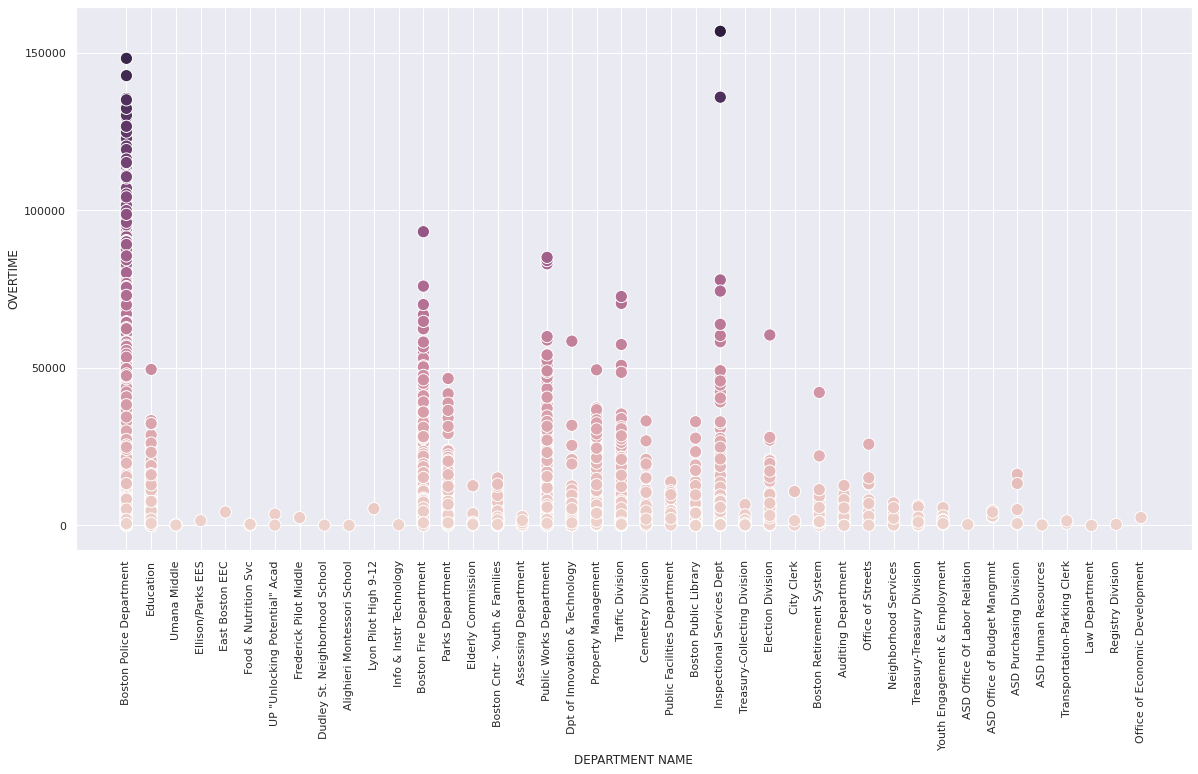

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

points = []
points_summed = []
for x in salaries_per_department:
    summation=0
    for y in range(0, len(salaries_per_department[x])):
        summation+=salaries_per_department[x][y]
        point = [x, salaries_per_department[x][y]]
        points.append(point)
    points_summed.append([x, summation])
        
our_cleaned_dataframe = pd.DataFrame(points, columns=["DEPARTMENT NAME", "OVERTIME"])
our_cleaned_sum_dataframe = pd.DataFrame(points_summed, columns=["DEPARTMENT NAME", "SUM SALARY PAYOUT"])


plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(65,40)})
sns.set(font_scale = 6)
sns.scatterplot(data=our_cleaned_dataframe, x="DEPARTMENT NAME", y="OVERTIME", hue="OVERTIME",legend = False, s=150)
plt.show()

#to add a legend: set legend = True;
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)





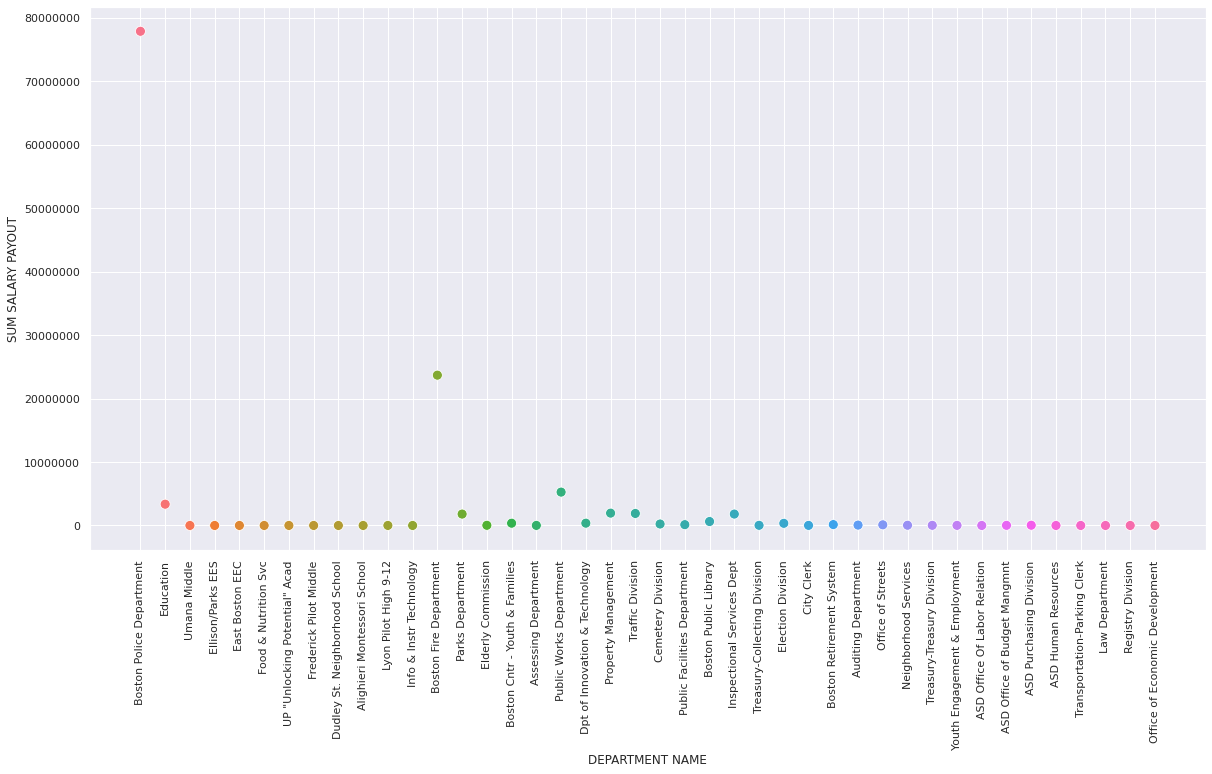

In [76]:
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(20,10)})
sns.scatterplot(data=our_cleaned_sum_dataframe, x="DEPARTMENT NAME", y="SUM SALARY PAYOUT", hue="DEPARTMENT NAME",legend = False, s=100)
plt.show()